In [362]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import xgboost
import shap

from sklearn import metrics
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import entropy

ModuleNotFoundError: No module named 'catenets'

In [41]:
ihdp = np.load('data/ihdp_npci_1-100.train.npz')

#### Variables in the .npz x, t, yf, ycf, mu0, mu1 are 
#### covariates, treatment, factual outcome, counterfactual outcome, and noiseless potential outcomes respectively.

print(ihdp.files)

['ate', 'mu1', 'mu0', 'yadd', 'yf', 'ycf', 't', 'x', 'ymul']


In [50]:
i_exp = 1

treatment = ihdp['t'][:,i_exp-1:i_exp]
data = {'x': ihdp['x'][:,:,i_exp-1], 't':treatment }

In [320]:

def propensity_score_training(data, label, mode):
    train_x, eva_x, train_t, eva_t = train_test_split(data, label, test_size=0.3, random_state=42)

    if mode == 'Logistic-regression':
        n_treat = np.sum(data)
        n_control = data.shape[0] - n_treat
        control_weight = n_treat/float(n_control)
        train_t = train_t.flatten()
        weight_array = np.ones([train_t.shape[0]])

        clf = LogisticRegression('l2', class_weight='balanced',C=3.0 )
        clf.fit(train_x, train_t.flatten())
        
        pred_eva = clf.predict(eva_x)
        pred_train = clf.predict(train_x)
        acc_train = accuracy_score(train_t, pred_train)
        f1_train = f1_score(train_t, pred_train)
        f1_eva = f1_score(eva_t, pred_eva)

        prob_eva = clf.predict_proba(eva_x)
        prob_train = clf.predict_proba(train_x)

        acc_eva = accuracy_score(eva_t, pred_eva)

        prob_all = clf.predict_proba(data)
        result_all = clf.predict(data)

        return prob_all, clf
    

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def KL(a, b):
    
    epsilon = 1e-35 
    a += epsilon
    b += epsilon

    return np.sum(a * np.log(a/b))

In [52]:
propensity_score, clf = propensity_score_training(data['x'], data['t'], 'Logistic-regression')

In [53]:
propensity_score

array([[0.58401875, 0.41598125],
       [0.40018499, 0.59981501],
       [0.83031042, 0.16968958],
       ...,
       [0.65020188, 0.34979812],
       [0.33423341, 0.66576659],
       [0.51458828, 0.48541172]])

Generate Synthetics Data from GANITE 2018

In [370]:
np.random.seed(0)

cov = np.random.uniform(low=-1, high=1, size=((10,10)))

### control 
mu0 = np.zeros(10)
x0 = np.random.multivariate_normal(mu0, 0.5*cov, size=5000)

### treated
mu1 = np.random.uniform(low=2.0, high=2.5, size=(10))
x1 = np.random.multivariate_normal(mu1, 0.5*cov, size=2500)

#### Treatment assignment

w_t = np.random.uniform(low=-0.1, high=0.1, size=((10,1)))
n_t = np.random.normal(0, 0.1)

t_x = sigmoid(np.dot(x0, w_t) + n_t)

print("KL between control vs treated %s"%KL(mu1,mu0))

#### Potential outcome

w_ty = np.random.uniform(low=-1, high=1, size=((10,2)))
n_ty = np.random.multivariate_normal(np.zeros((2)), 0.1*np.eye(2))


p_control_y = np.dot(x0, w_ty) + n_ty
p_treated_y = np.dot(x1, w_ty) + n_ty

KL between control vs treated 1853.6271653211952


covariance is not positive-semidefinite.
covariance is not positive-semidefinite.


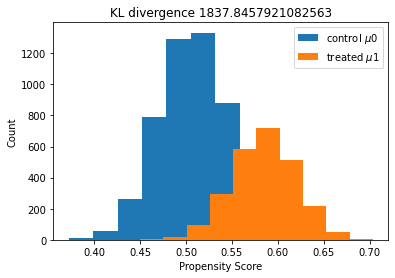

In [369]:
plt.hist(sigmoid(np.dot(x0, w_t) + n_t), label = "control $\mu0$")
plt.hist(sigmoid(np.dot(x1, w_t) + n_t), label = "treated $\mu1$")

plt.ylabel("Count")
plt.xlabel("Propensity Score")
plt.title('KL divergence %s' % KL(mu1,mu0))
plt.legend()

(array([  1.,  10.,  71., 289., 650., 737., 482., 220.,  36.,   4.]),
 array([-8.08971208, -6.60422061, -5.11872914, -3.63323768, -2.14774621,
        -0.66225474,  0.82323673,  2.30872819,  3.79421966,  5.27971113,
         6.76520259]),
 <BarContainer object of 10 artists>)

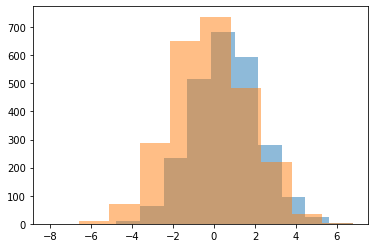

In [324]:
plt.hist(p_treated_y[:, 1], alpha=0.5)
plt.hist(p_treated_y[:, 0], alpha=0.5)

In [325]:
# explain the model's predictions using SHAP

x_control = np.concatenate((x0[:1500,: ], np.zeros((1500,1))), axis=1)
x_treated = np.concatenate((x1[:1500,: ], np.ones((1500,1))), axis=1)

x_cf_control = np.concatenate((x0[:1500,: ], np.ones((1500,1))), axis=1)
x_cf_treated = np.concatenate((x1[:1500,: ], np.zeros((1500,1))), axis=1)

x_train = np.concatenate((x_control[:1000, :],x_treated[:1000,:]), axis=0)
y_train = np.concatenate((p_control_y[:1000:,0], p_treated_y[:1000,1]))

### generating two testing sets

X_f_test = np.concatenate((x_cf_control[1000:1500,: ],x_cf_treated[1000:1500, :]), axis=0)
y_f_test = np.concatenate((p_control_y[1000:1500:,0], p_treated_y[1000:1500,1]))

X_cf_test = np.concatenate((x_cf_control[:1000,: ],x_cf_treated[:1000, :]), axis=0)
y_cf_test = np.concatenate((p_control_y[:1000:,1], p_treated_y[:1000,0]))

#### OLS

model = xgboost.XGBRegressor().fit(x_train, y_train)
y_f_pred = model.predict(X_f_test)
y_cf_pred = model.predict(X_cf_test)

#### propensity score model - PSM

ps = LogisticRegression()
ps.fit(x_train[:,:10], x_train[:,10:])
ps_score = ps.predict_proba(x_train[:,:10])[:,1]
true_ps_score = sigmoid(np.dot(x_train[:,:10], w_t) + n_t)

model_ps = xgboost.XGBRegressor().fit(x_train, y_train/(true_ps_score.reshape(-1,)))
y_f_pred_ps = model_ps.predict(X_f_test)
y_cf_pred_ps = model_ps.predict(X_cf_test)


print("factual loss in testing data %s; %s"%(np.mean(y_f_test - y_f_pred)**2, np.mean(y_f_test - y_f_pred_ps)**2))
print("counterfactual loss in testing data %s; %s"%(np.mean(y_cf_test - y_cf_pred)**2, np.mean(y_cf_test - y_cf_pred_ps)**2))

factual loss in testing data 0.0005732225509558112; 0.02735235827140879
counterfactual loss in testing data 0.0016028544284897941; 0.04103012550287249


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


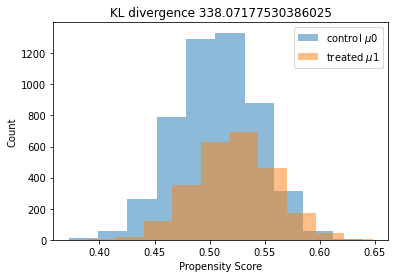

In [303]:
plt.hist(sigmoid(np.dot(x0, w_t) + n_t), label = "control $\mu0$", alpha=0.5)
plt.hist(sigmoid(np.dot(x1, w_t) + n_t), label = "treated $\mu1$", alpha=0.5)

plt.ylabel("Count")
plt.xlabel("Propensity Score")
plt.title('KL divergence %s' % KL(mu1,mu0))
plt.legend()

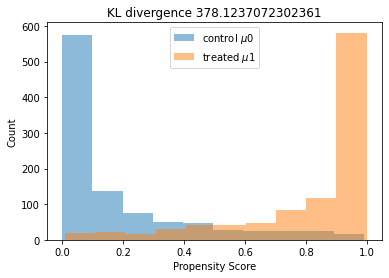

In [316]:
plt.hist(ps_score[:1000],label = "control $\mu0$", alpha = 0.5)
plt.hist(ps_score[1000:], label = "treated $\mu1$",alpha = 0.5)

plt.ylabel("Count")
plt.xlabel("Propensity Score")
plt.title('KL divergence %s' % KL(mu1,mu0))
plt.legend()

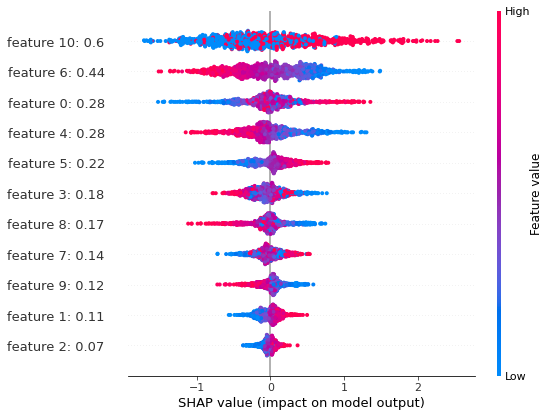

In [349]:
explainer = shap.Explainer(model, x_train)
shap_values = explainer(X_f_test)

names = ["feature " + str(i) for i in range(11)]
feature_names = [ a + ": " + str(b) for a,b in zip(names, np.abs(shap_values.values).mean(0).round(2))]

shap.summary_plot(shap_values, feature_names=feature_names)

unbiased = (shap_values.values).mean(0)
unbiased_abs = np.abs(shap_values.values).mean(0)

Comparison between true coefficient and shap



In [361]:
w_control = w_ty[:,0]
w_treated = w_ty[:,1]

print(unbiased, unbiased_abs)

print(stats.spearmanr(unbiased_abs[:10] , w_treated ))
stats.spearmanr(unbiased[:10] , w_treated )

[-0.01922009 -0.01406322 -0.02184566 -0.05786632 -0.02117733  0.00120943
  0.01482325 -0.02214452 -0.02611639  0.00830238  0.00308276] [0.27944418 0.10869801 0.06835664 0.18269321 0.27827878 0.21839151
 0.43657417 0.13752684 0.17216228 0.12005712 0.59966818]
SpearmanrResult(correlation=-0.6, pvalue=0.06668799999999996)


SpearmanrResult(correlation=0.05454545454545454, pvalue=0.8810361811618526)

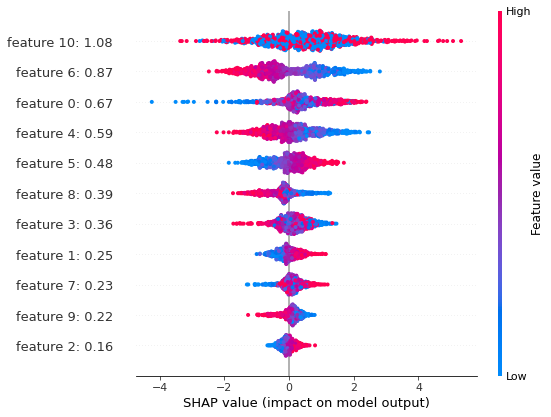

[ 0.38056438 -0.02842893 -0.02790794  0.13907011  0.07730657  0.00357061
 -0.06665015  0.11569091 -0.22853952  0.06925912  0.56592977]
[-0.01922009 -0.01406322 -0.02184566 -0.05786632 -0.02117733  0.00120943
  0.01482325 -0.02214452 -0.02611639  0.00830238  0.00308276]
SpearmanrResult(correlation=-0.07272727272727274, pvalue=0.831716405381337)


In [317]:
explainer = shap.Explainer(model_ps, x_train)
shap_values = explainer(X_f_test)

names = ["feature " + str(i) for i in range(11)]
feature_names = [ a + ": " + str(b) for a,b in zip(names, np.abs(shap_values.values).mean(0).round(2))]

shap.summary_plot(shap_values, feature_names=feature_names)

biased = (shap_values.values).mean(0)
print(biased)
print(unbiased)

print(stats.spearmanr(unbiased , biased))

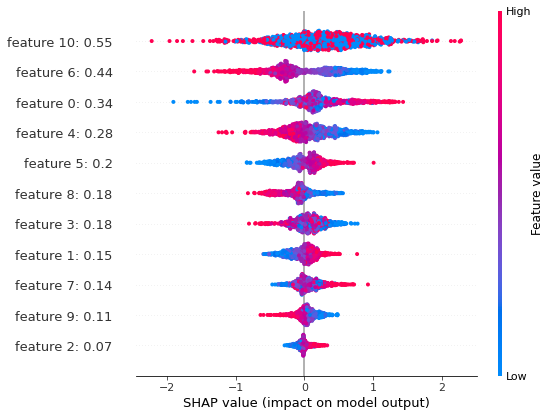

[ 0.19272781 -0.02315055 -0.0120793   0.06544144  0.05595323 -0.00175396
 -0.04294274  0.06722634 -0.09965305  0.03949211  0.28088219]
[-0.01922009 -0.01406322 -0.02184566 -0.05786632 -0.02117733  0.00120943
  0.01482325 -0.02214452 -0.02611639  0.00830238  0.00308276]
SpearmanrResult(correlation=-0.05454545454545456, pvalue=0.8734465775233149)


In [318]:
explainer = shap.Explainer(model, x_train)
shap_values = explainer(X_f_test)

names = ["feature " + str(i) for i in range(11)]
feature_names = [ a + ": " + str(b) for a,b in zip(names, np.abs(shap_values.values).mean(0).round(2))]

shap.summary_plot(shap_values, feature_names=feature_names)

biased = (shap_values.values).mean(0)
print(biased)
print(unbiased)
print(stats.spearmanr(unbiased , biased))


In [266]:
np.random.seed(0)


mu_t = np.arange(0, 0.8, 0.05, dtype=float)

ols_results = np.zeros((4, len(mu_t)))
psm_results = np.zeros((4, len(mu_t)))
iptw_results = np.zeros((4, len(mu_t)))

KL_results = []

iptw_loss =  np.zeros((2, len(mu_t)))
ols_loss = np.zeros((2, len(mu_t)))

for i, value in enumerate(mu_t):

    cov = np.random.uniform(low=-1, high=1, size=((10,10)))
    
    ### control 
    mu0 = np.zeros(10)
    x0 = np.random.multivariate_normal(mu0, 0.5*cov, size=5000)
    
    ### treated
    mu1 = np.random.uniform(low=value, high=(value+0.05), size=(10))
    x1 = np.random.multivariate_normal(mu1, 0.5*cov, size=2500)

    #### Treatment assignment

    w_t = np.random.uniform(low=-0.1, high=0.1, size=((10,1)))
    n_t = np.random.normal(0, 0.1)

    t_x = sigmoid(np.dot(x0, w_t) + n_t)
    
    KL_results.append(KL(mu1,mu0))
    print("KL between control vs treated %s"%KL(mu1,mu0))

    #### Potential outcome

    w_ty = np.random.uniform(low=-1, high=1, size=((10,2)))
    n_ty = np.random.multivariate_normal(np.zeros((2)), 0.1*np.eye(2))

    p_control_y = np.dot(x0, w_ty) + n_ty
    p_treated_y = np.dot(x1, w_ty) + n_ty


    # explain the model's predictions using SHAP

    x_control = np.concatenate((x0[:1500,: ], np.zeros((1500,1))), axis=1)
    x_treated = np.concatenate((x1[:1500,: ], np.ones((1500,1))), axis=1)

    x_cf_control = np.concatenate((x0[:1500,: ], np.ones((1500,1))), axis=1)
    x_cf_treated = np.concatenate((x1[:1500,: ], np.zeros((1500,1))), axis=1)

    x_train = np.concatenate((x_control[:1000, :],x_treated[:1000,:]), axis=0)
    y_train = np.concatenate((p_control_y[:1000:,0], p_treated_y[:1000,1]))


    ### generating two testing sets

    X_f_test = np.concatenate((x_cf_control[1000:1500,: ],x_cf_treated[1000:1500, :]), axis=0)
    y_f_test = np.concatenate((p_control_y[1000:1500:,0], p_treated_y[1000:1500,1]))

    X_cf_test = np.concatenate((x_cf_control[:1000,: ],x_cf_treated[:1000, :]), axis=0)
    y_cf_test = np.concatenate((p_control_y[:1000:,1], p_treated_y[:1000,0]))

    #### OLS

    model = xgboost.XGBRegressor().fit(x_train, y_train)
    y_f_pred = model.predict(X_f_test)
    y_cf_pred = model.predict(X_cf_test)

    explainer = shap.Explainer(model, x_train)
    shap_values = explainer(X_f_test)
    feature_imp = (shap_values.values).mean(0).round(2)
    feature_imp_abs = np.abs(shap_values.values).mean(0).round(2)

    ols_results[0, i] = stats.spearmanr(unbiased , feature_imp).correlation
    ols_results[1, i] = stats.spearmanr(unbiased_abs , feature_imp_abs).correlation

    ols_results[2, i] = stats.pearsonr(unbiased , feature_imp)[0]
    ols_results[3, i] = stats.pearsonr(unbiased_abs , feature_imp_abs)[0]
    #### propensity score model - PSM

    ### PS function 

    ps = LogisticRegression()
    ps.fit(x_train[:,:10], x_train[:,10:])
    ps_score = ps.predict_proba(x_train[:,:10])[:,1]
    true_ps_score = sigmoid(np.dot(x_train[:,:10], w_t) + n_t)

    true_ps_score_control = sigmoid(np.dot(x_control[:,:10], w_t) + n_t)
    true_ps_score_tx = sigmoid(np.dot(x_treated[:,:10], w_t) + n_t)
    
    min_ps = max(min(true_ps_score_control),min(true_ps_score_tx))
    max_ps = min(max(true_ps_score_control),max(true_ps_score_tx))
    index = (true_ps_score < (max_ps - 0.05)) & (true_ps_score > (min_ps + 0.05))

    model_psm = xgboost.XGBRegressor().fit(x_train[index.reshape(-1),:], y_train[index.reshape(-1)])
    #y_f_pred_ps = model_ps.predict(X_f_test)
    #y_cf_pred_ps = model_ps.predict(X_cf_test)
    
    explainer = shap.Explainer(model_psm, x_train[index.reshape(-1),:])
    shap_values = explainer(X_f_test)
    
    feature_imp = (shap_values.values).mean(0).round(2)
    feature_imp_abs = np.abs(shap_values.values).mean(0).round(2)
    
    psm_results[0, i] = stats.spearmanr(unbiased , feature_imp).correlation
    psm_results[1, i] = stats.spearmanr(unbiased_abs , feature_imp_abs).correlation
    psm_results[2, i] = stats.pearsonr(unbiased , feature_imp)[0]
    psm_results[3, i] = stats.pearsonr(unbiased_abs , feature_imp_abs)[0]
    
    
    model_iptw = xgboost.XGBRegressor().fit(x_train, y_train/(true_ps_score.reshape(-1,)))
    y_f_pred_ps = model_ps.predict(X_f_test)
    y_cf_pred_ps = model_ps.predict(X_cf_test)

    explainer = shap.Explainer(model_iptw, x_train)
    shap_values = explainer(X_f_test)
    feature_imp = (shap_values.values).mean(0).round(2)
    feature_imp_abs = np.abs(shap_values.values).mean(0).round(2)

    iptw_results[0, i] = stats.spearmanr(unbiased , feature_imp).correlation
    iptw_results[1, i] = stats.spearmanr(unbiased_abs , feature_imp_abs).correlation
    iptw_results[2, i] = stats.pearsonr(unbiased , feature_imp)[0]
    iptw_results[3, i] = stats.pearsonr(unbiased_abs , feature_imp_abs)[0]
    
    iptw_loss[0,i] = np.mean(y_f_test - y_f_pred_ps)**2
    iptw_loss[1,i] = np.mean(y_cf_test - y_cf_pred_ps)**2

    ols_loss[0,i] = np.mean(y_f_test - y_f_pred)**2
    ols_loss[1,i] = np.mean(y_cf_test - y_cf_pred)**2    

covariance is not positive-semidefinite.
covariance is not positive-semidefinite.


KL between control vs treated 21.14929677008321


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
covariance is not positive-semidefinite.
covariance is not positive-semidefinite.


KL between control vs treated 60.60387392739546


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
covariance is not positive-semidefinite.
covariance is not positive-semidefinite.


KL between control vs treated 97.55908039652428


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
covariance is not positive-semidefinite.
covariance is not positive-semidefinite.


KL between control vs treated 132.69040064546414


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
covariance is not positive-semidefinite.
covariance is not positive-semidefinite.


KL between control vs treated 173.11977369232008


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
covariance is not positive-semidefinite.
covariance is not positive-semidefinite.


KL between control vs treated 214.5605956741896


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
covariance is not positive-semidefinite.
covariance is not positive-semidefinite.


KL between control vs treated 250.20573023918686


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
covariance is not positive-semidefinite.
covariance is not positive-semidefinite.


KL between control vs treated 294.12503052048265


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
covariance is not positive-semidefinite.
covariance is not positive-semidefinite.


KL between control vs treated 333.2918927174383


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
covariance is not positive-semidefinite.
covariance is not positive-semidefinite.


KL between control vs treated 373.9060435847497


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
covariance is not positive-semidefinite.
covariance is not positive-semidefinite.


KL between control vs treated 419.42986976714366


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
covariance is not positive-semidefinite.
covariance is not positive-semidefinite.


KL between control vs treated 457.82497346156555


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
covariance is not positive-semidefinite.
covariance is not positive-semidefinite.


KL between control vs treated 497.5879428354863


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
covariance is not positive-semidefinite.
covariance is not positive-semidefinite.


KL between control vs treated 538.1483751897061


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
covariance is not positive-semidefinite.
covariance is not positive-semidefinite.


KL between control vs treated 577.2240213073404


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
covariance is not positive-semidefinite.
covariance is not positive-semidefinite.


KL between control vs treated 624.8287930698457


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


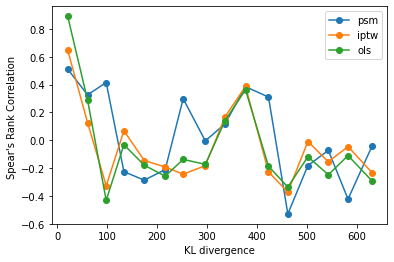

In [267]:
plt.plot(KL_results, psm_results[0,:],"-o", label="psm")
plt.plot(KL_results, iptw_results[0,:],"-o", label="iptw" )
plt.plot(KL_results, ols_results[0,:],"-o", label="ols")

plt.xlabel("KL divergence")
plt.ylabel("Spear's Rank Correlation ")
plt.legend()

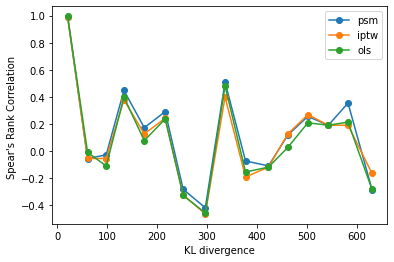

In [269]:
plt.plot(KL_results, psm_results[1,:],"-o", label="psm")
plt.plot(KL_results, iptw_results[1,:],"-o", label="iptw")
plt.plot(KL_results, ols_results[1,:],"-o", label="ols")

plt.xlabel("KL divergence")
plt.ylabel("Spear's Rank Correlation ")
plt.legend()

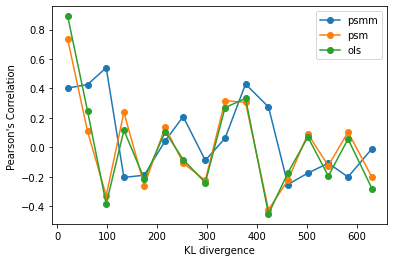

In [270]:
plt.plot(KL_results, psm_results[2,:],"-o", label="psmm")
plt.plot(KL_results, iptw_results[2,:],"-o", label="psm")
plt.plot(KL_results, ols_results[2,:],"-o", label="ols")

plt.xlabel("KL divergence")
plt.ylabel("Pearson's Correlation ")
plt.legend()

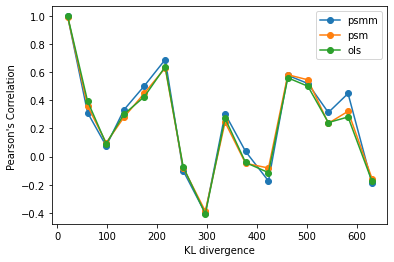

In [263]:

plt.plot(KL_results, psm_results[3,:],"-o", label="psmm")
plt.plot(KL_results, iptw_results[3,:],"-o", label="psm")
plt.plot(KL_results, ols_results[3,:],"-o", label="ols")

plt.xlabel("KL divergence")
plt.ylabel("Pearson's Correlation ")
plt.legend()

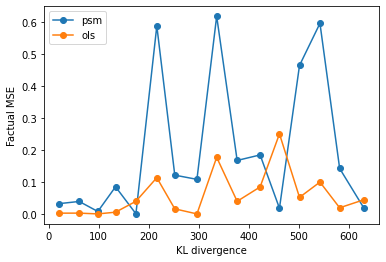

In [231]:
plt.plot(KL_results, iptw_loss[0,:],"-o", label="iptw")
plt.plot(KL_results, ols_loss[0,:],"-o", label="ols")

plt.xlabel("KL divergence")
plt.ylabel("Factual MSE")
plt.legend()

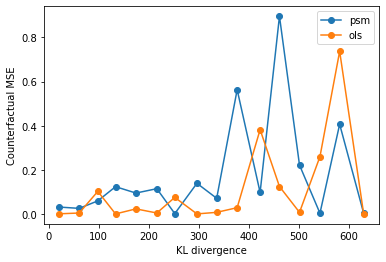

In [232]:
plt.plot(KL_results, iptw_loss[1,:],"-o", label="iptw")
plt.plot(KL_results, ols_loss[1,:],"-o", label="ols")

plt.xlabel("KL divergence")
plt.ylabel("Counterfactual MSE")
plt.legend()

(-0.7426106572325057, 0.1505558088534455)